In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap

In [25]:
alphabet_dict = {"p": 0, "-": 1, "A": 2, "C": 3, "G": 4, "T": 5}
lab2onehot =  lambda seq: torch.eye(len(alphabet_dict))[seq]
seq2lab = lambda seq: torch.tensor([alphabet_dict[i] for i in seq])

In [26]:
def label(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0])))
    for i,seq in enumerate(seqs):
        encoded_seq = torch.tensor([alphabet_dict[a] for a in seq])
        encoded_seqs[i,:] = encoded_seq
    return encoded_seqs

def onehot(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0]), len(alphabet_dict)))
    for i,seq in enumerate(seqs):
        encoded_seq = seq2lab(seq)
        encoded_seq_onehot = lab2onehot(encoded_seq)
        encoded_seqs[i,:,:] = encoded_seq_onehot
    return encoded_seqs

def calculate_prob_matrix(seqs, alphabet_dict):    
    onehot_vect = onehot(seqs, alphabet_dict)
    return (onehot_vect.sum(dim=0).T / onehot_vect.sum(dim=[0,2])).T

In [27]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Add flatten layer and bottle neck to reduce flatten layer dimension
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8064, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
            
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, num_channels, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, num_channels):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Bottleneck linear layer
        self.bottleneck = nn.Linear(2048, 128)  # Adjust your_input_length
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid activation for the output to constrain values between 0 and 1
        )

    def l1_regularization(self):
        l1_reg = 0.0
        for param in self.encoder.parameters():
            l1_reg += torch.sum(torch.abs(param))
        return l1_reg

    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.bottleneck(x)
        # print(x.shape)
        x = x.view(x.size(0), 32, -1)
        # print(x.shape)
        x = self.decoder(x)  # Adjust your_input_length
        # print(x.shape)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        return x

In [28]:
df_aligned = pd.read_csv("C:/Users/khoah/PhD_Documents/SPLASH/compactor_classified_small_aligned.csv")


In [29]:
df_aligned.anchor_event.unique()

array(['Internal_splicing', 'splicing', 'Repeat', '3UTR', 'Centromere',
       'Base_pair_change_1', 'Base_pair_change_6'], dtype=object)

In [30]:
#filter for anchor event == splicing or centromere
df_aligned = df_aligned[df_aligned["anchor_event"].isin(["splicing", "Base_pair_change_1"])]

In [31]:
msas = df_aligned.groupby("anchor_index").agg(list).aligned_compactor.to_list()
msa_prob_encoded = [calculate_prob_matrix(msa, alphabet_dict) for msa in msas]
padded_sequences = pad_sequence(msa_prob_encoded, batch_first=True, padding_value=0)
input_seqs = torch.swapaxes(padded_sequences, 1,2)

In [32]:
# divide into train and test set
train_size = int(0.8 * len(input_seqs))
test_size = len(input_seqs) - train_size
train_set, test_set = torch.utils.data.random_split(input_seqs, [train_size, test_size])
print("train set size: ", len(train_set))
print("test set size: ", len(test_set))

train set size:  1051
test set size:  263


In [33]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
# Instantiate the model
model = Autoencoder(6)

# Choose a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
# use cross entropy loss for classification
# cross_entropy = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
train_loss = []
test_loss = []
for epoch in range(num_epochs):

    # train in batch
    batch_size = 128
    for i in range(0, len(train_set), batch_size):
        batch = train_set[i:i+batch_size]
        outputs = model(batch)
        reconstruction_loss = criterion(outputs, batch)
        sparsity_loss = 0.0000 * model.l1_regularization()
        loss = reconstruction_loss + sparsity_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # # Forward pass
    # outputs = model(train_set.dataset[train_set.indices])
    # loss = criterion(outputs, train_set.dataset[train_set.indices])

    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # Print progress
    with torch.no_grad():
        print("Sparsity_Loss = ", sparsity_loss.item())
        outputs = model(train_set.dataset[train_set.indices])
        train_loss_ = criterion(outputs, train_set.dataset[train_set.indices])
        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train loss: {train_loss_.item():.4f}')
        outputs = model(test_set.dataset[test_set.indices])
        test_loss_ = criterion(outputs, test_set.dataset[test_set.indices])
        print(f'Test loss: {test_loss_.item():.4f}')

    # save test loss and rain loss in lists
    train_loss.append(train_loss_.item())
    test_loss.append(test_loss_.item())

# Test the model
with torch.no_grad():
    outputs = model(test_set.dataset[test_set.indices])
    loss = criterion(outputs, test_set.dataset[test_set.indices])
    print(f'Test loss: {loss.item():.4f}')

Using cpu device
Sparsity_Loss =  0.0
Epoch [1/300]
Train loss: 0.1981
Test loss: 0.1984
Sparsity_Loss =  0.0
Epoch [2/300]
Train loss: 0.1101
Test loss: 0.1102
Sparsity_Loss =  0.0
Epoch [3/300]
Train loss: 0.1073
Test loss: 0.1073
Sparsity_Loss =  0.0
Epoch [4/300]
Train loss: 0.0998
Test loss: 0.0997
Sparsity_Loss =  0.0
Epoch [5/300]
Train loss: 0.0906
Test loss: 0.0905
Sparsity_Loss =  0.0
Epoch [6/300]
Train loss: 0.0858
Test loss: 0.0858
Sparsity_Loss =  0.0
Epoch [7/300]
Train loss: 0.0838
Test loss: 0.0840
Sparsity_Loss =  0.0
Epoch [8/300]
Train loss: 0.0831
Test loss: 0.0834
Sparsity_Loss =  0.0
Epoch [9/300]
Train loss: 0.0828
Test loss: 0.0830
Sparsity_Loss =  0.0
Epoch [10/300]
Train loss: 0.0826
Test loss: 0.0829
Sparsity_Loss =  0.0
Epoch [11/300]
Train loss: 0.0826
Test loss: 0.0828
Sparsity_Loss =  0.0
Epoch [12/300]
Train loss: 0.0825
Test loss: 0.0828
Sparsity_Loss =  0.0
Epoch [13/300]
Train loss: 0.0825
Test loss: 0.0828
Sparsity_Loss =  0.0
Epoch [14/300]
Train l

Sparsity_Loss =  0.0
Epoch [113/300]
Train loss: 0.0634
Test loss: 0.0657
Sparsity_Loss =  0.0
Epoch [114/300]
Train loss: 0.0633
Test loss: 0.0655
Sparsity_Loss =  0.0
Epoch [115/300]
Train loss: 0.0627
Test loss: 0.0650
Sparsity_Loss =  0.0
Epoch [116/300]
Train loss: 0.0630
Test loss: 0.0654
Sparsity_Loss =  0.0
Epoch [117/300]
Train loss: 0.0615
Test loss: 0.0639
Sparsity_Loss =  0.0
Epoch [118/300]
Train loss: 0.0609
Test loss: 0.0633
Sparsity_Loss =  0.0
Epoch [119/300]
Train loss: 0.0605
Test loss: 0.0631
Sparsity_Loss =  0.0
Epoch [120/300]
Train loss: 0.0613
Test loss: 0.0639
Sparsity_Loss =  0.0
Epoch [121/300]
Train loss: 0.0596
Test loss: 0.0621
Sparsity_Loss =  0.0
Epoch [122/300]
Train loss: 0.0593
Test loss: 0.0619
Sparsity_Loss =  0.0
Epoch [123/300]
Train loss: 0.0587
Test loss: 0.0613
Sparsity_Loss =  0.0
Epoch [124/300]
Train loss: 0.0582
Test loss: 0.0610
Sparsity_Loss =  0.0
Epoch [125/300]
Train loss: 0.0578
Test loss: 0.0607
Sparsity_Loss =  0.0
Epoch [126/300]
T

Sparsity_Loss =  0.0
Epoch [224/300]
Train loss: 0.0449
Test loss: 0.0574
Sparsity_Loss =  0.0
Epoch [225/300]
Train loss: 0.0450
Test loss: 0.0574
Sparsity_Loss =  0.0
Epoch [226/300]
Train loss: 0.0450
Test loss: 0.0576
Sparsity_Loss =  0.0
Epoch [227/300]
Train loss: 0.0453
Test loss: 0.0578
Sparsity_Loss =  0.0
Epoch [228/300]
Train loss: 0.0453
Test loss: 0.0576
Sparsity_Loss =  0.0
Epoch [229/300]
Train loss: 0.0442
Test loss: 0.0567
Sparsity_Loss =  0.0
Epoch [230/300]
Train loss: 0.0439
Test loss: 0.0567
Sparsity_Loss =  0.0
Epoch [231/300]
Train loss: 0.0442
Test loss: 0.0571
Sparsity_Loss =  0.0
Epoch [232/300]
Train loss: 0.0447
Test loss: 0.0575
Sparsity_Loss =  0.0
Epoch [233/300]
Train loss: 0.0444
Test loss: 0.0572
Sparsity_Loss =  0.0
Epoch [234/300]
Train loss: 0.0433
Test loss: 0.0564
Sparsity_Loss =  0.0
Epoch [235/300]
Train loss: 0.0425
Test loss: 0.0558
Sparsity_Loss =  0.0
Epoch [236/300]
Train loss: 0.0428
Test loss: 0.0565
Sparsity_Loss =  0.0
Epoch [237/300]
T

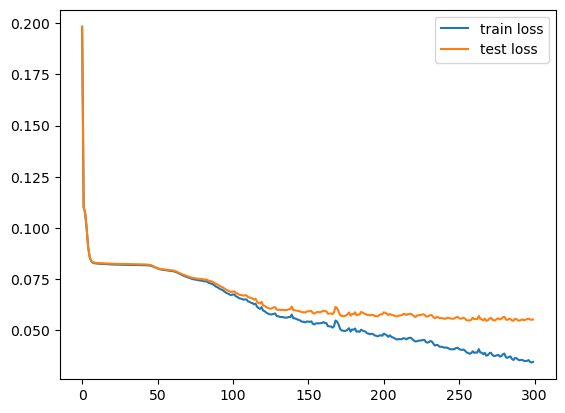

In [35]:
# plot train and test loss
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")

plt.legend()

random sequence index:  176


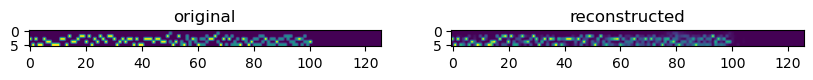

In [36]:
with torch.no_grad():
    outputs = model(train_set.dataset[train_set.indices])
#visualize the results for a random sequence
rand_seq = np.random.randint(0, len(train_set.indices))
print("random sequence index: ", rand_seq)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_set.dataset[train_set.indices][rand_seq])
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(outputs[rand_seq])
plt.title("reconstructed")
plt.show()

random sequence index:  204


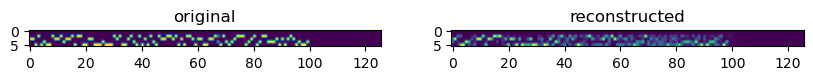

In [65]:
#visualize the results for a random sequence
with torch.no_grad():
    outputs = model(test_set.dataset[test_set.indices])
rand_seq = np.random.randint(0, len(test_set.indices))
print("random sequence index: ", rand_seq)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_set.dataset[test_set.indices][rand_seq])
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(outputs[rand_seq])
plt.title("reconstructed")
plt.show()

In [38]:
color_map = {"splicing": 1, "Centromere": 0, "Base_pair_change_1": 2}
labels = [color_map[i] for i in df_aligned.groupby("anchor_index").anchor_event.first().to_list()]
len(labels)


1314

In [54]:
df_aligned.groupby("anchor_index").aligned_compactor

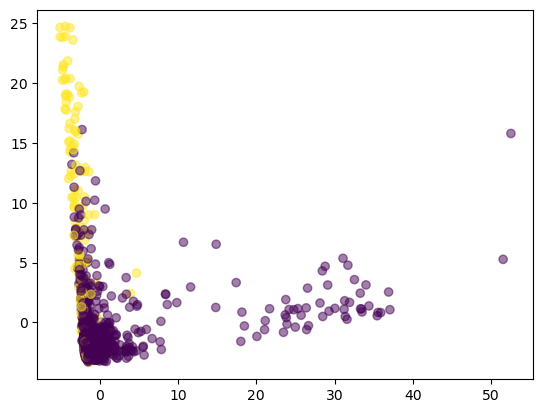

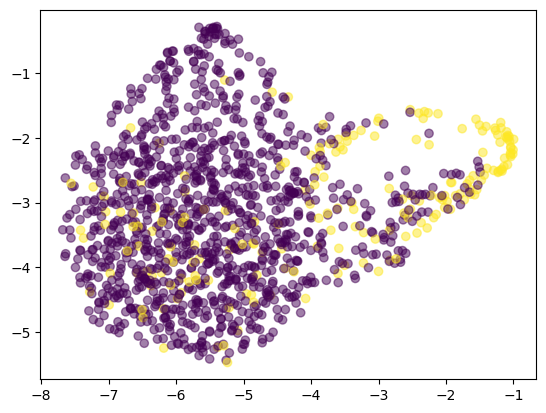

In [39]:
pca = PCA(n_components=2)
with torch.no_grad():
    outputs = input_seqs.flatten(start_dim=1)
    # scale the data using standard scaler
    scaler = StandardScaler()
    outputs = scaler.fit_transform(outputs)
    outputs = pca.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()

# perform umap on raw data
reducer = umap.UMAP()
with torch.no_grad():
    outputs = input_seqs.flatten(start_dim=1)
    outputs = scaler.fit_transform(outputs)
    outputs = reducer.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()

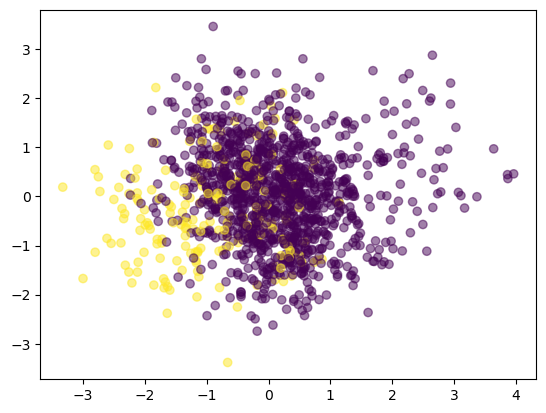

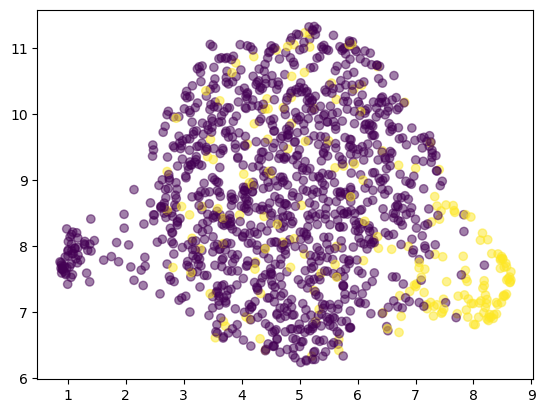

In [40]:
# perform pca on the bottleneck layer
pca = PCA(n_components=2)
with torch.no_grad():
    outputs = model.encode(input_seqs)
    outputs = outputs.numpy()
    outputs = pca.fit_transform(outputs)
    scaler = StandardScaler()
    outputs = scaler.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()
reducer = umap.UMAP()
with torch.no_grad():
    outputs = model.encode(input_seqs)
    outputs = reducer.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()